# Road Damage Detection Dataset - Data Exploration
## Comprehensive Analysis of Kaggle Road Infrastructure Datasets

This notebook provides a thorough exploration of road damage detection datasets from Kaggle, including:
- Dataset structure and organization analysis
- Class distribution and balance assessment
- Image quality and resolution analysis
- Annotation quality verification
- Damage type characteristics study
- Dataset recommendations for training

**Supported Datasets:**
1. Lorenzo Arcioni - Road Damage Dataset: Potholes, Cracks and Manholes
2. Alvaro Basily - Road Damage Dataset
3. Custom datasets in YOLO format

## Dependencies Installation

**Required packages for this notebook:**

### Core Dependencies:
- `matplotlib` - Plotting and visualization
- `seaborn` - Statistical data visualization
- `pandas` - Data manipulation and analysis
- `numpy` - Numerical computing
- `opencv-python` - Computer vision operations
- `pillow` - Image processing
- `scikit-learn` - Machine learning utilities

### Optional Dependencies:
- `plotly` - Interactive visualizations
- `kaggle` - Kaggle API for dataset download

### Installation Commands:
```bash
# Essential packages
pip install matplotlib seaborn pandas numpy opencv-python pillow scikit-learn

# Optional packages
pip install plotly kaggle
```

**OR install all at once:**
```bash
pip install matplotlib seaborn pandas numpy opencv-python pillow scikit-learn plotly kaggle
```

In [19]:
# # Automatic package installation (run this cell first)
# import subprocess
# import sys

# def install_package(package):
#     """Install a package using pip"""
#     subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# # Required packages for data exploration
# required_packages = [
#     "matplotlib",
#     "seaborn", 
#     "pandas",
#     "numpy",
#     "opencv-python",
#     "pillow",
#     "scikit-learn"
# ]

# optional_packages = [
#     "plotly",
#     "kaggle"
# ]

# print("Installing required packages...")
# for package in required_packages:
#     try:
#         __import__(package.replace("-", "_"))
#         print(f"  {package}: Already installed")
#     except ImportError:
#         print(f"  Installing {package}...")
#         install_package(package)
#         print(f"  {package}: Installed successfully")

# print("\nInstalling optional packages...")
# for package in optional_packages:
#     try:
#         __import__(package.replace("-", "_"))
#         print(f"  {package}: Already installed")
#     except ImportError:
#         try:
#             print(f"  Installing {package}...")
#             install_package(package)
#             print(f"  {package}: Installed successfully")
#         except Exception as e:
#             print(f"  {package}: Installation failed - {e}")

# print("\nPackage installation completed!")

In [20]:
# Import required libraries
import os
import sys
import json
import yaml
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
from collections import Counter, defaultdict
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For statistical analysis
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Optional imports
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("Plotly not available - using matplotlib for all plots")

try:
    import kaggle
    KAGGLE_AVAILABLE = True
except ImportError:
    KAGGLE_AVAILABLE = False
    print("Kaggle API not available - manual download required")

print("Libraries imported successfully!")
print(f"Plotly available: {PLOTLY_AVAILABLE}")
print(f"Kaggle API available: {KAGGLE_AVAILABLE}")

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set random seed for reproducibility
np.random.seed(42)

Libraries imported successfully!
Plotly available: True
Kaggle API available: True


In [21]:
# Configuration
CONFIG = {
    # Dataset Configuration
    'DATASET_CHOICE': 1,  # 1: Lorenzo Arcioni, 2: Alvaro Basily, 3: Custom
    'KAGGLE_DATASETS': {
        1: 'lorenzoarcioni/road-damage-dataset-potholes-cracks-and-manholes',
        2: 'alvarobasily/road-damage',
        3: 'your-username/your-dataset'  # Replace with your dataset
    },
    'DATA_DIR': 'road_damage_data',
    'DOWNLOAD_DATASET': False,  # Set to True for automatic download
    
    # Analysis Configuration
    'SAMPLE_SIZE': 100,  # Number of images to analyze in detail
    'MAX_IMAGES_DISPLAY': 20,  # Maximum images to display in grid
    'FIGURE_SIZE': (15, 10),
    'DPI': 300,
    
    # Output Configuration
    'OUTPUT_DIR': 'exploration_results',
    'SAVE_PLOTS': True,
    'GENERATE_REPORT': True,
    
    # Common road damage class mappings
    'CLASS_MAPPINGS': {
        'lorenzo_arcioni': {
            0: 'pothole',
            1: 'longitudinal_crack',
            2: 'lateral_crack',
            3: 'alligator_crack',
            4: 'manhole'
        },
        'alvaro_basily': {
            0: 'pothole',
            1: 'alligator_crack', 
            2: 'longitudinal_crack',
            3: 'lateral_crack'
        },
        'default': {
            0: 'damage_type_0',
            1: 'damage_type_1',
            2: 'damage_type_2',
            3: 'damage_type_3',
            4: 'damage_type_4'
        }
    }
}

# Create output directory
os.makedirs(CONFIG['OUTPUT_DIR'], exist_ok=True)
os.makedirs(CONFIG['DATA_DIR'], exist_ok=True)

print("Configuration loaded successfully!")
print(f"Selected dataset: {CONFIG['KAGGLE_DATASETS'][CONFIG['DATASET_CHOICE']]}")
print(f"Output directory: {CONFIG['OUTPUT_DIR']}")

Configuration loaded successfully!
Selected dataset: lorenzoarcioni/road-damage-dataset-potholes-cracks-and-manholes
Output directory: exploration_results


## Dataset Download and Setup

In [22]:
def download_kaggle_dataset(dataset_name, download_path):
    """
    Download dataset from Kaggle
    """
    if not KAGGLE_AVAILABLE:
        print("Kaggle API not available. Please download dataset manually.")
        return False
    
    try:
        print(f"Downloading dataset: {dataset_name}")
        kaggle.api.dataset_download_files(
            dataset_name, 
            path=download_path, 
            unzip=True
        )
        print(f"Dataset downloaded and extracted to: {download_path}")
        return True
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        return False

# Download dataset if configured
selected_dataset = CONFIG['KAGGLE_DATASETS'][CONFIG['DATASET_CHOICE']]

if CONFIG['DOWNLOAD_DATASET'] and KAGGLE_AVAILABLE:
    success = download_kaggle_dataset(selected_dataset, CONFIG['DATA_DIR'])
    if not success:
        print("Automatic download failed. Please download manually.")
else:
    print("MANUAL DOWNLOAD INSTRUCTIONS")
    print("=" * 50)
    print(f"1. Go to: https://www.kaggle.com/datasets/{selected_dataset}")
    print("2. Click 'Download' button")
    print(f"3. Extract ZIP file to: {CONFIG['DATA_DIR']}")
    print("4. Ensure the structure matches YOLO format:")
    print("   road_damage_data/")
    print("   ├── images/")
    print("   │   ├── train/")
    print("   │   ├── val/")
    print("   │   └── test/")
    print("   └── labels/")
    print("       ├── train/")
    print("       ├── val/")
    print("       └── test/")
    print("")
    print("RECOMMENDED DATASETS:")
    print("1. Lorenzo Arcioni (2,000+ images, high quality)")
    print("2. Alvaro Basily (3,321+ images, good variety)")
    print("=" * 50)

MANUAL DOWNLOAD INSTRUCTIONS
1. Go to: https://www.kaggle.com/datasets/lorenzoarcioni/road-damage-dataset-potholes-cracks-and-manholes
2. Click 'Download' button
3. Extract ZIP file to: road_damage_data
4. Ensure the structure matches YOLO format:
   road_damage_data/
   ├── images/
   │   ├── train/
   │   ├── val/
   │   └── test/
   └── labels/
       ├── train/
       ├── val/
       └── test/

RECOMMENDED DATASETS:
1. Lorenzo Arcioni (2,000+ images, high quality)
2. Alvaro Basily (3,321+ images, good variety)


In [23]:
import shutil
from pathlib import Path
import numpy as np

def fix_dataset_structure(data_dir):
    """Convert flat dataset structure to YOLO format"""
    data_dir = Path(data_dir)
    
    print("SPLITTING DATASET")
    print("=" * 50)
    
    # Check if images are directly in images/ folder
    images_dir = data_dir / 'images'
    labels_dir = data_dir / 'labels'
    
    # Get all images directly in images/ folder
    direct_images = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
        direct_images.extend(list(images_dir.glob(ext)))
    
    direct_labels = list(labels_dir.glob('*.txt')) if labels_dir.exists() else []
    
    print(f"Found {len(direct_images)} images directly in images/ folder")
    print(f"Found {len(direct_labels)} labels directly in labels/ folder")
    
    if len(direct_images) == 0:
        print("No images found in flat structure")
        return False
    
    # Create train/val/test directories
    for split in ['train', 'val', 'test']:
        (images_dir / split).mkdir(exist_ok=True)
        (labels_dir / split).mkdir(exist_ok=True)
    
    # Get image stems for splitting
    image_stems = [img.stem for img in direct_images]
    np.random.shuffle(image_stems)
    
    # Split: 70% train, 20% val, 10% test
    n_total = len(image_stems)
    n_train = int(0.7 * n_total)
    n_val = int(0.2 * n_total)
    
    splits = {
        'train': image_stems[:n_train],
        'val': image_stems[n_train:n_train + n_val],
        'test': image_stems[n_train + n_val:]
    }
    
    print(f"\nSplitting into: {len(splits['train'])} train, {len(splits['val'])} val, {len(splits['test'])} test")
    
    # Move files
    for split_name, stems in splits.items():
        moved_images = 0
        moved_labels = 0
        
        for stem in stems:
            # Find and move image
            for ext in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']:
                src_img = images_dir / f'{stem}{ext}'
                if src_img.exists():
                    dst_img = images_dir / split_name / src_img.name
                    if not dst_img.exists():
                        shutil.move(str(src_img), str(dst_img))
                        moved_images += 1
                        break
            
            # Move corresponding label
            src_lbl = labels_dir / f'{stem}.txt'
            if src_lbl.exists():
                dst_lbl = labels_dir / split_name / src_lbl.name
                if not dst_lbl.exists():
                    shutil.move(str(src_lbl), str(dst_lbl))
                    moved_labels += 1
        
        print(f"  {split_name}: moved {moved_images} images, {moved_labels} labels")
    
    print("\nSUCCESS: Dataset converted to YOLO format!")
    return True

# Run the fix
success = fix_dataset_structure('road_damage_data')
if not success:
    print("Dataset split failed. Please check the dataset manually.")


SPLITTING DATASET
Found 4018 images directly in images/ folder
Found 2009 labels directly in labels/ folder

Splitting into: 2812 train, 803 val, 403 test
  train: moved 1840 images, 1840 labels
  val: moved 146 images, 146 labels
  test: moved 23 images, 23 labels

SUCCESS: Dataset converted to YOLO format!


## Dataset Structure Analysis

In [24]:
class DatasetExplorer:
    """
    Comprehensive dataset exploration class for road damage detection
    """
    
    def __init__(self, data_dir, class_mapping=None):
        self.data_dir = Path(data_dir)
        self.class_mapping = class_mapping or {}
        self.dataset_info = {}
        self.image_stats = []
        self.annotation_stats = []
        
    def analyze_dataset_structure(self):
        """
        Analyze the overall structure of the dataset
        """
        print("ANALYZING DATASET STRUCTURE")
        print("=" * 50)
        
        if not self.data_dir.exists():
            print(f"ERROR: Dataset directory not found: {self.data_dir}")
            return None
        
        # Check for YOLO format structure
        required_dirs = ['images', 'labels']
        splits = ['train', 'val', 'test']
        
        structure_info = {
            'has_yolo_structure': all((self.data_dir / d).exists() for d in required_dirs),
            'splits': {},
            'total_images': 0,
            'total_labels': 0,
            'file_formats': set(),
            'directory_structure': []
        }
        
        # Analyze each split
        for split in splits:
            img_dir = self.data_dir / 'images' / split
            lbl_dir = self.data_dir / 'labels' / split
            
            split_info = {
                'images': 0,
                'labels': 0,
                'matched': 0,
                'orphaned_images': 0,
                'orphaned_labels': 0
            }
            
            if img_dir.exists():
                images = list(img_dir.glob('*.[jJ][pP][gG]')) + list(img_dir.glob('*.[pP][nN][gG]')) + list(img_dir.glob('*.[jJ][pP][eE][gG]'))
                split_info['images'] = len(images)
                structure_info['total_images'] += len(images)
                
                # Track file formats
                for img in images:
                    structure_info['file_formats'].add(img.suffix.lower())
            
            if lbl_dir.exists():
                labels = list(lbl_dir.glob('*.txt'))
                split_info['labels'] = len(labels)
                structure_info['total_labels'] += len(labels)
            
            # Check for matched image-label pairs
            if img_dir.exists() and lbl_dir.exists():
                img_stems = {img.stem for img in img_dir.glob('*.[jJ][pP][gG]')} | {img.stem for img in img_dir.glob('*.[pP][nN][gG]')}
                lbl_stems = {lbl.stem for lbl in lbl_dir.glob('*.txt')}
                
                split_info['matched'] = len(img_stems & lbl_stems)
                split_info['orphaned_images'] = len(img_stems - lbl_stems)
                split_info['orphaned_labels'] = len(lbl_stems - img_stems)
            
            structure_info['splits'][split] = split_info
        
        # Generate directory tree
        structure_info['directory_structure'] = self._get_directory_tree(self.data_dir)
        
        self.dataset_info['structure'] = structure_info
        
        # Display results
        print(f"Dataset Directory: {self.data_dir}")
        print(f"YOLO Structure: {'YES' if structure_info['has_yolo_structure'] else 'NO'}")
        print(f"Total Images: {structure_info['total_images']:,}")
        print(f"Total Labels: {structure_info['total_labels']:,}")
        print(f"File Formats: {', '.join(structure_info['file_formats'])}")
        print()
        
        # Split breakdown
        print("SPLIT BREAKDOWN:")
        for split, info in structure_info['splits'].items():
            if info['images'] > 0 or info['labels'] > 0:
                print(f"  {split.upper()}:")
                print(f"    Images: {info['images']:,}")
                print(f"    Labels: {info['labels']:,}")
                print(f"    Matched pairs: {info['matched']:,}")
                if info['orphaned_images'] > 0:
                    print(f"    WARNING: Orphaned images: {info['orphaned_images']}")
                if info['orphaned_labels'] > 0:
                    print(f"    WARNING: Orphaned labels: {info['orphaned_labels']}")
                print()
        
        return structure_info
    
    def _get_directory_tree(self, path, prefix="", max_depth=3, current_depth=0):
        """
        Generate a directory tree structure
        """
        if current_depth >= max_depth:
            return []
        
        tree = []
        if path.is_dir():
            items = sorted(path.iterdir(), key=lambda x: (x.is_file(), x.name))
            for i, item in enumerate(items[:10]):  # Limit to first 10 items
                is_last = i == len(items) - 1
                current_prefix = "└── " if is_last else "├── "
                tree.append(f"{prefix}{current_prefix}{item.name}")
                
                if item.is_dir() and current_depth < max_depth - 1:
                    extension = "    " if is_last else "│   "
                    tree.extend(self._get_directory_tree(
                        item, prefix + extension, max_depth, current_depth + 1
                    ))
            
            if len(items) > 10:
                tree.append(f"{prefix}... and {len(items) - 10} more items")
        
        return tree

# Initialize dataset explorer
if os.path.exists(CONFIG['DATA_DIR']) and os.listdir(CONFIG['DATA_DIR']):
    # Determine class mapping based on dataset choice
    if CONFIG['DATASET_CHOICE'] == 1:
        class_mapping = CONFIG['CLASS_MAPPINGS']['lorenzo_arcioni']
    elif CONFIG['DATASET_CHOICE'] == 2:
        class_mapping = CONFIG['CLASS_MAPPINGS']['alvaro_basily']
    else:
        class_mapping = CONFIG['CLASS_MAPPINGS']['default']
    
    explorer = DatasetExplorer(CONFIG['DATA_DIR'], class_mapping)
    structure_info = explorer.analyze_dataset_structure()
    
    if structure_info:
        print("\nDIRECTORY STRUCTURE:")
        for line in structure_info['directory_structure'][:20]:  # Show first 20 lines
            print(line)
        if len(structure_info['directory_structure']) > 20:
            print("... (truncated)")
    
else:
    print(f"\nERROR: Dataset directory '{CONFIG['DATA_DIR']}' is empty or doesn't exist.")
    print("Please download and extract the dataset first.")
    explorer = None
    structure_info = None

ANALYZING DATASET STRUCTURE
Dataset Directory: road_damage_data
YOLO Structure: YES
Total Images: 2,009
Total Labels: 2,009
File Formats: .jpg

SPLIT BREAKDOWN:
  TRAIN:
    Images: 1,840
    Labels: 1,840
    Matched pairs: 1,840

  VAL:
    Images: 146
    Labels: 146
    Matched pairs: 146

  TEST:
    Images: 23
    Labels: 23
    Matched pairs: 23


DIRECTORY STRUCTURE:
├── images
│   ├── test
│   │   ├── vlcsnap-00029.jpg
│   │   ├── vlcsnap-00060.jpg
│   │   ├── vlcsnap-00090.jpg
│   │   ├── vlcsnap-2025-02-18-18h32m56s495.jpg
│   │   ├── vlcsnap-2025-02-18-18h36m53s784.jpg
│   │   ├── vlcsnap-2025-02-18-23h25m01s474.jpg
│   │   ├── vlcsnap-2025-02-18-23h28m43s566.jpg
│   │   ├── vlcsnap-2025-02-18-23h29m04s331.jpg
│   │   ├── vlcsnap-2025-02-18-23h29m48s551.jpg
│   │   ├── vlcsnap-2025-02-19-14h12m12s513.jpg
│   │   ... and 13 more items
│   ├── train
│   │   ├── 20250216_164325.jpg
│   │   ├── 20250216_164521.jpg
│   │   ├── 20250216_164541.jpg
│   │   ├── 20250219_164649.jpg


## Annotation Analysis

In [30]:
import numpy as np
from pathlib import Path

def convert_polygon_to_yolo_bbox(data_dir):
    """Convert polygon annotations to YOLO bounding box format"""
    data_dir = Path(data_dir)
    
    print("CONVERTING POLYGON TO YOLO BOUNDING BOX FORMAT")
    print("=" * 60)
    
    converted_files = 0
    total_objects = 0
    
    for split in ['train', 'val', 'test']:
        label_dir = data_dir / 'labels' / split
        if not label_dir.exists():
            continue
        
        split_files = 0
        split_objects = 0
        
        for label_file in label_dir.glob('*.txt'):
            try:
                with open(label_file, 'r') as f:
                    lines = f.readlines()
                
                converted_lines = []
                
                for line in lines:
                    line = line.strip()
                    if not line:
                        continue
                    
                    parts = line.split()
                    
                    # Check if it's polygon format (9 parts)
                    if len(parts) == 9:
                        try:
                            class_id = int(parts[0])
                            # Extract the 8 coordinates (4 points)
                            coords = [float(x) for x in parts[1:9]]
                            
                            # Group into points: (x1,y1), (x2,y2), (x3,y3), (x4,y4)
                            points = [(coords[i], coords[i+1]) for i in range(0, 8, 2)]
                            
                            # Calculate bounding box from polygon points
                            x_coords = [p[0] for p in points]
                            y_coords = [p[1] for p in points]
                            
                            x_min = min(x_coords)
                            x_max = max(x_coords)
                            y_min = min(y_coords)
                            y_max = max(y_coords)
                            
                            # Convert to YOLO format (center, width, height)
                            x_center = (x_min + x_max) / 2
                            y_center = (y_min + y_max) / 2
                            width = x_max - x_min
                            height = y_max - y_min
                            
                            # Create YOLO format line
                            yolo_line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
                            converted_lines.append(yolo_line + "\n")
                            split_objects += 1
                            
                        except (ValueError, IndexError) as e:
                            print(f"Error processing line in {label_file.name}: {line}")
                            continue
                    
                    # If already in YOLO format (5 parts), keep as is
                    elif len(parts) == 5:
                        converted_lines.append(line + "\n")
                        split_objects += 1
                    
                    else:
                        print(f"Skipping unknown format in {label_file.name}: {len(parts)} parts")
                
                # Write converted annotations back to file
                if converted_lines:
                    with open(label_file, 'w') as f:
                        f.writelines(converted_lines)
                    split_files += 1
                    
            except Exception as e:
                print(f"Error processing {label_file}: {e}")
        
        if split_files > 0:
            print(f"  {split}: converted {split_files} files, {split_objects} objects")
            converted_files += split_files
            total_objects += split_objects
    
    print(f"\nSUCCESS: Converted {converted_files} files with {total_objects} objects!")
    return converted_files > 0

# Run the conversion
success = convert_polygon_to_yolo_bbox('road_damage_data')

if success:
    print("\nYOLO CONVERSION COMPLETE!")


CONVERTING POLYGON TO YOLO BOUNDING BOX FORMAT
  train: converted 1840 files, 4331 objects
  val: converted 146 files, 345 objects
  test: converted 23 files, 61 objects

SUCCESS: Converted 2009 files with 4737 objects!

YOLO CONVERSION COMPLETE!


In [31]:
def analyze_annotations(explorer):
    """
    Comprehensive analysis of YOLO annotations
    """
    if not explorer or not explorer.dataset_info.get('structure'):
        print("ERROR: Cannot analyze annotations - dataset not loaded")
        return None
    
    print("ANALYZING ANNOTATIONS")
    print("=" * 50)
    
    annotation_stats = {
        'class_distribution': Counter(),
        'bbox_stats': {'widths': [], 'heights': [], 'areas': [], 'aspect_ratios': []},
        'objects_per_image': [],
        'split_distribution': {},
        'annotation_quality': {'valid': 0, 'invalid': 0, 'empty': 0},
        'spatial_distribution': {'x_centers': [], 'y_centers': []}
    }
    
    splits = ['train', 'val', 'test']
    
    for split in splits:
        label_dir = explorer.data_dir / 'labels' / split
        if not label_dir.exists():
            continue
        
        split_stats = {
            'class_count': Counter(),
            'total_objects': 0,
            'total_images': 0
        }
        
        label_files = list(label_dir.glob('*.txt'))
        print(f"Processing {len(label_files)} label files in {split} split...")
        
        for label_file in label_files:
            split_stats['total_images'] += 1
            
            try:
                with open(label_file, 'r') as f:
                    lines = f.readlines()
                
                if not lines or all(not line.strip() for line in lines):
                    annotation_stats['annotation_quality']['empty'] += 1
                    annotation_stats['objects_per_image'].append(0)
                    continue
                
                objects_in_image = 0
                
                for line in lines:
                    line = line.strip()
                    if not line:
                        continue
                    
                    try:
                        parts = line.split()
                        if len(parts) != 5:
                            annotation_stats['annotation_quality']['invalid'] += 1
                            continue
                        
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:5])
                        
                        # Validate coordinates (should be between 0 and 1)
                        if not all(0 <= coord <= 1 for coord in [x_center, y_center, width, height]):
                            annotation_stats['annotation_quality']['invalid'] += 1
                            continue
                        
                        # Valid annotation
                        annotation_stats['annotation_quality']['valid'] += 1
                        annotation_stats['class_distribution'][class_id] += 1
                        split_stats['class_count'][class_id] += 1
                        split_stats['total_objects'] += 1
                        objects_in_image += 1
                        
                        # Bbox statistics
                        annotation_stats['bbox_stats']['widths'].append(width)
                        annotation_stats['bbox_stats']['heights'].append(height)
                        annotation_stats['bbox_stats']['areas'].append(width * height)
                        annotation_stats['bbox_stats']['aspect_ratios'].append(width / height if height > 0 else 0)
                        
                        # Spatial distribution
                        annotation_stats['spatial_distribution']['x_centers'].append(x_center)
                        annotation_stats['spatial_distribution']['y_centers'].append(y_center)
                        
                    except (ValueError, IndexError) as e:
                        annotation_stats['annotation_quality']['invalid'] += 1
                        continue
                
                annotation_stats['objects_per_image'].append(objects_in_image)
                
            except Exception as e:
                print(f"Error processing {label_file}: {e}")
                annotation_stats['annotation_quality']['invalid'] += 1
        
        annotation_stats['split_distribution'][split] = split_stats
    
    # Convert to numpy arrays for statistics
    for key in annotation_stats['bbox_stats']:
        annotation_stats['bbox_stats'][key] = np.array(annotation_stats['bbox_stats'][key])
    
    annotation_stats['objects_per_image'] = np.array(annotation_stats['objects_per_image'])
    
    # Display results
    print(f"\nANNOTATION SUMMARY:")
    print(f"Valid annotations: {annotation_stats['annotation_quality']['valid']:,}")
    print(f"Invalid annotations: {annotation_stats['annotation_quality']['invalid']:,}")
    print(f"Empty label files: {annotation_stats['annotation_quality']['empty']:,}")
    
    total_annotations = sum(annotation_stats['annotation_quality'].values())
    if total_annotations > 0:
        quality_percentage = (annotation_stats['annotation_quality']['valid'] / total_annotations) * 100
        print(f"Annotation quality: {quality_percentage:.1f}%")
    
    print(f"\nCLASS DISTRIBUTION:")
    total_objects = sum(annotation_stats['class_distribution'].values())
    for class_id, count in sorted(annotation_stats['class_distribution'].items()):
        class_name = explorer.class_mapping.get(class_id, f'Class_{class_id}')
        percentage = (count / total_objects * 100) if total_objects > 0 else 0
        print(f"  {class_name}: {count:,} ({percentage:.1f}%)")
    
    print(f"\nBOUNDING BOX STATISTICS:")
    if len(annotation_stats['bbox_stats']['widths']) > 0:
        for stat_name, values in annotation_stats['bbox_stats'].items():
            if len(values) > 0:
                print(f"  {stat_name.replace('_', ' ').title()}:")
                print(f"    Mean: {np.mean(values):.4f}")
                print(f"    Std:  {np.std(values):.4f}")
                print(f"    Min:  {np.min(values):.4f}")
                print(f"    Max:  {np.max(values):.4f}")
    
    print(f"\nOBJECTS PER IMAGE:")
    if len(annotation_stats['objects_per_image']) > 0:
        print(f"  Mean: {np.mean(annotation_stats['objects_per_image']):.2f}")
        print(f"  Std:  {np.std(annotation_stats['objects_per_image']):.2f}")
        print(f"  Min:  {np.min(annotation_stats['objects_per_image'])}")
        print(f"  Max:  {np.max(annotation_stats['objects_per_image'])}")
        
        # Distribution of objects per image
        obj_counts = Counter(annotation_stats['objects_per_image'])
        print(f"  Distribution:")
        for obj_count, freq in sorted(obj_counts.items())[:10]:  # Show first 10
            print(f"    {obj_count} objects: {freq} images")
    
    explorer.dataset_info['annotations'] = annotation_stats
    return annotation_stats

# Run annotation analysis
if explorer:
    annotation_stats = analyze_annotations(explorer)
else:
    annotation_stats = None

ANALYZING ANNOTATIONS
Processing 1840 label files in train split...
Processing 146 label files in val split...
Processing 23 label files in test split...

ANNOTATION SUMMARY:
Valid annotations: 4,737
Invalid annotations: 0
Empty label files: 0
Annotation quality: 100.0%

CLASS DISTRIBUTION:
  pothole: 1,261 (26.6%)
  longitudinal_crack: 2,519 (53.2%)
  lateral_crack: 957 (20.2%)

BOUNDING BOX STATISTICS:
  Widths:
    Mean: 0.1255
    Std:  0.1069
    Min:  0.0031
    Max:  1.0000
  Heights:
    Mean: 0.1053
    Std:  0.0886
    Min:  0.0000
    Max:  0.9972
  Areas:
    Mean: 0.0200
    Std:  0.0505
    Min:  0.0000
    Max:  0.9167
  Aspect Ratios:
    Mean: 1.3616
    Std:  0.7663
    Min:  0.0000
    Max:  13.9689

OBJECTS PER IMAGE:
  Mean: 2.36
  Std:  1.52
  Min:  1
  Max:  13
  Distribution:
    1 objects: 722 images
    2 objects: 564 images
    3 objects: 346 images
    4 objects: 203 images
    5 objects: 84 images
    6 objects: 52 images
    7 objects: 19 images
    8 obje

## Image Quality Analysis

In [32]:
def analyze_image_quality(explorer, sample_size=100):
    """
    Analyze image quality metrics including resolution, format, and characteristics
    """
    if not explorer:
        print("ERROR: Cannot analyze images - dataset not loaded")
        return None
    
    print("ANALYZING IMAGE QUALITY")
    print("=" * 50)
    
    image_stats = {
        'resolutions': [],
        'widths': [],
        'heights': [],
        'aspect_ratios': [],
        'file_sizes': [],
        'formats': Counter(),
        'channels': Counter(),
        'color_stats': {'mean_brightness': [], 'std_brightness': []},
        'quality_issues': {'corrupted': 0, 'too_small': 0, 'unusual_aspect': 0}
    }
    
    # Collect all image paths
    all_images = []
    for split in ['train', 'val', 'test']:
        img_dir = explorer.data_dir / 'images' / split
        if img_dir.exists():
            images = list(img_dir.glob('*.[jJ][pP][gG]')) + list(img_dir.glob('*.[pP][nN][gG]')) + list(img_dir.glob('*.[jJ][pP][eE][gG]'))
            all_images.extend(images)
    
    if not all_images:
        print("ERROR: No images found in dataset")
        return None
    
    # Sample images for detailed analysis
    sample_images = np.random.choice(all_images, min(sample_size, len(all_images)), replace=False)
    
    print(f"Analyzing {len(sample_images)} sample images...")
    
    for i, img_path in enumerate(sample_images):
        if i % 20 == 0:
            print(f"  Progress: {i}/{len(sample_images)}")
        
        try:
            # Basic file info
            file_size = img_path.stat().st_size
            image_stats['file_sizes'].append(file_size)
            image_stats['formats'][img_path.suffix.lower()] += 1
            
            # Load image with PIL for basic info
            with Image.open(img_path) as img:
                width, height = img.size
                image_stats['widths'].append(width)
                image_stats['heights'].append(height)
                image_stats['resolutions'].append(width * height)
                image_stats['aspect_ratios'].append(width / height if height > 0 else 0)
                image_stats['channels'][len(img.getbands())] += 1
                
                # Quality checks
                if width < 100 or height < 100:
                    image_stats['quality_issues']['too_small'] += 1
                
                aspect_ratio = width / height if height > 0 else 0
                if aspect_ratio < 0.5 or aspect_ratio > 2.0:
                    image_stats['quality_issues']['unusual_aspect'] += 1
            
            # Load with OpenCV for color analysis
            img_cv = cv2.imread(str(img_path))
            if img_cv is not None:
                # Convert to grayscale for brightness analysis
                gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
                image_stats['color_stats']['mean_brightness'].append(np.mean(gray))
                image_stats['color_stats']['std_brightness'].append(np.std(gray))
            
        except Exception as e:
            image_stats['quality_issues']['corrupted'] += 1
            print(f"Error processing {img_path}: {e}")
    
    # Convert to numpy arrays
    for key in ['resolutions', 'widths', 'heights', 'aspect_ratios', 'file_sizes']:
        image_stats[key] = np.array(image_stats[key])
    
    for key in image_stats['color_stats']:
        image_stats['color_stats'][key] = np.array(image_stats['color_stats'][key])
    
    # Display results
    print(f"\nIMAGE STATISTICS (from {len(sample_images)} samples):")
    
    print(f"\nRESOLUTION ANALYSIS:")
    if len(image_stats['widths']) > 0:
        print(f"  Width  - Mean: {np.mean(image_stats['widths']):.0f}, Std: {np.std(image_stats['widths']):.0f}")
        print(f"  Height - Mean: {np.mean(image_stats['heights']):.0f}, Std: {np.std(image_stats['heights']):.0f}")
        print(f"  Most common resolutions:")
        
        # Find most common resolutions
        resolution_pairs = [(w, h) for w, h in zip(image_stats['widths'], image_stats['heights'])]
        resolution_counts = Counter(resolution_pairs)
        for (w, h), count in resolution_counts.most_common(5):
            percentage = (count / len(resolution_pairs)) * 100
            print(f"    {w}x{h}: {count} images ({percentage:.1f}%)")
    
    print(f"\nFILE INFORMATION:")
    if len(image_stats['file_sizes']) > 0:
        avg_size_mb = np.mean(image_stats['file_sizes']) / (1024 * 1024)
        print(f"  Average file size: {avg_size_mb:.2f} MB")
        print(f"  File formats:")
        for fmt, count in image_stats['formats'].most_common():
            percentage = (count / len(sample_images)) * 100
            print(f"    {fmt}: {count} files ({percentage:.1f}%)")
    
    print(f"\nCOLOR INFORMATION:")
    print(f"  Channel distribution:")
    for channels, count in sorted(image_stats['channels'].items()):
        channel_type = {1: 'Grayscale', 3: 'RGB', 4: 'RGBA'}.get(channels, f'{channels}-channel')
        percentage = (count / len(sample_images)) * 100
        print(f"    {channel_type}: {count} images ({percentage:.1f}%)")
    
    if len(image_stats['color_stats']['mean_brightness']) > 0:
        print(f"  Brightness - Mean: {np.mean(image_stats['color_stats']['mean_brightness']):.1f}/255")
        print(f"  Brightness - Std:  {np.std(image_stats['color_stats']['mean_brightness']):.1f}")
    
    print(f"\nQUALITY ISSUES:")
    total_issues = sum(image_stats['quality_issues'].values())
    for issue, count in image_stats['quality_issues'].items():
        percentage = (count / len(sample_images)) * 100
        print(f"  {issue.replace('_', ' ').title()}: {count} images ({percentage:.1f}%)")
    
    if total_issues == 0:
        print("  SUCCESS: No quality issues detected!")
    
    explorer.dataset_info['images'] = image_stats
    return image_stats

# Run image quality analysis
if explorer:
    image_stats = analyze_image_quality(explorer, CONFIG['SAMPLE_SIZE'])
else:
    image_stats = None

ANALYZING IMAGE QUALITY
Analyzing 100 sample images...
  Progress: 0/100
  Progress: 20/100
  Progress: 40/100
  Progress: 60/100
  Progress: 80/100

IMAGE STATISTICS (from 100 samples):

RESOLUTION ANALYSIS:
  Width  - Mean: 640, Std: 0
  Height - Mean: 360, Std: 0
  Most common resolutions:
    640x360: 100 images (100.0%)

FILE INFORMATION:
  Average file size: 0.09 MB
  File formats:
    .jpg: 100 files (100.0%)

COLOR INFORMATION:
  Channel distribution:
    RGB: 100 images (100.0%)
  Brightness - Mean: 105.3/255
  Brightness - Std:  17.8

QUALITY ISSUES:
  Corrupted: 0 images (0.0%)
  Too Small: 0 images (0.0%)
  Unusual Aspect: 0 images (0.0%)
  SUCCESS: No quality issues detected!


## Data Visualization

CREATING VISUALIZATIONS


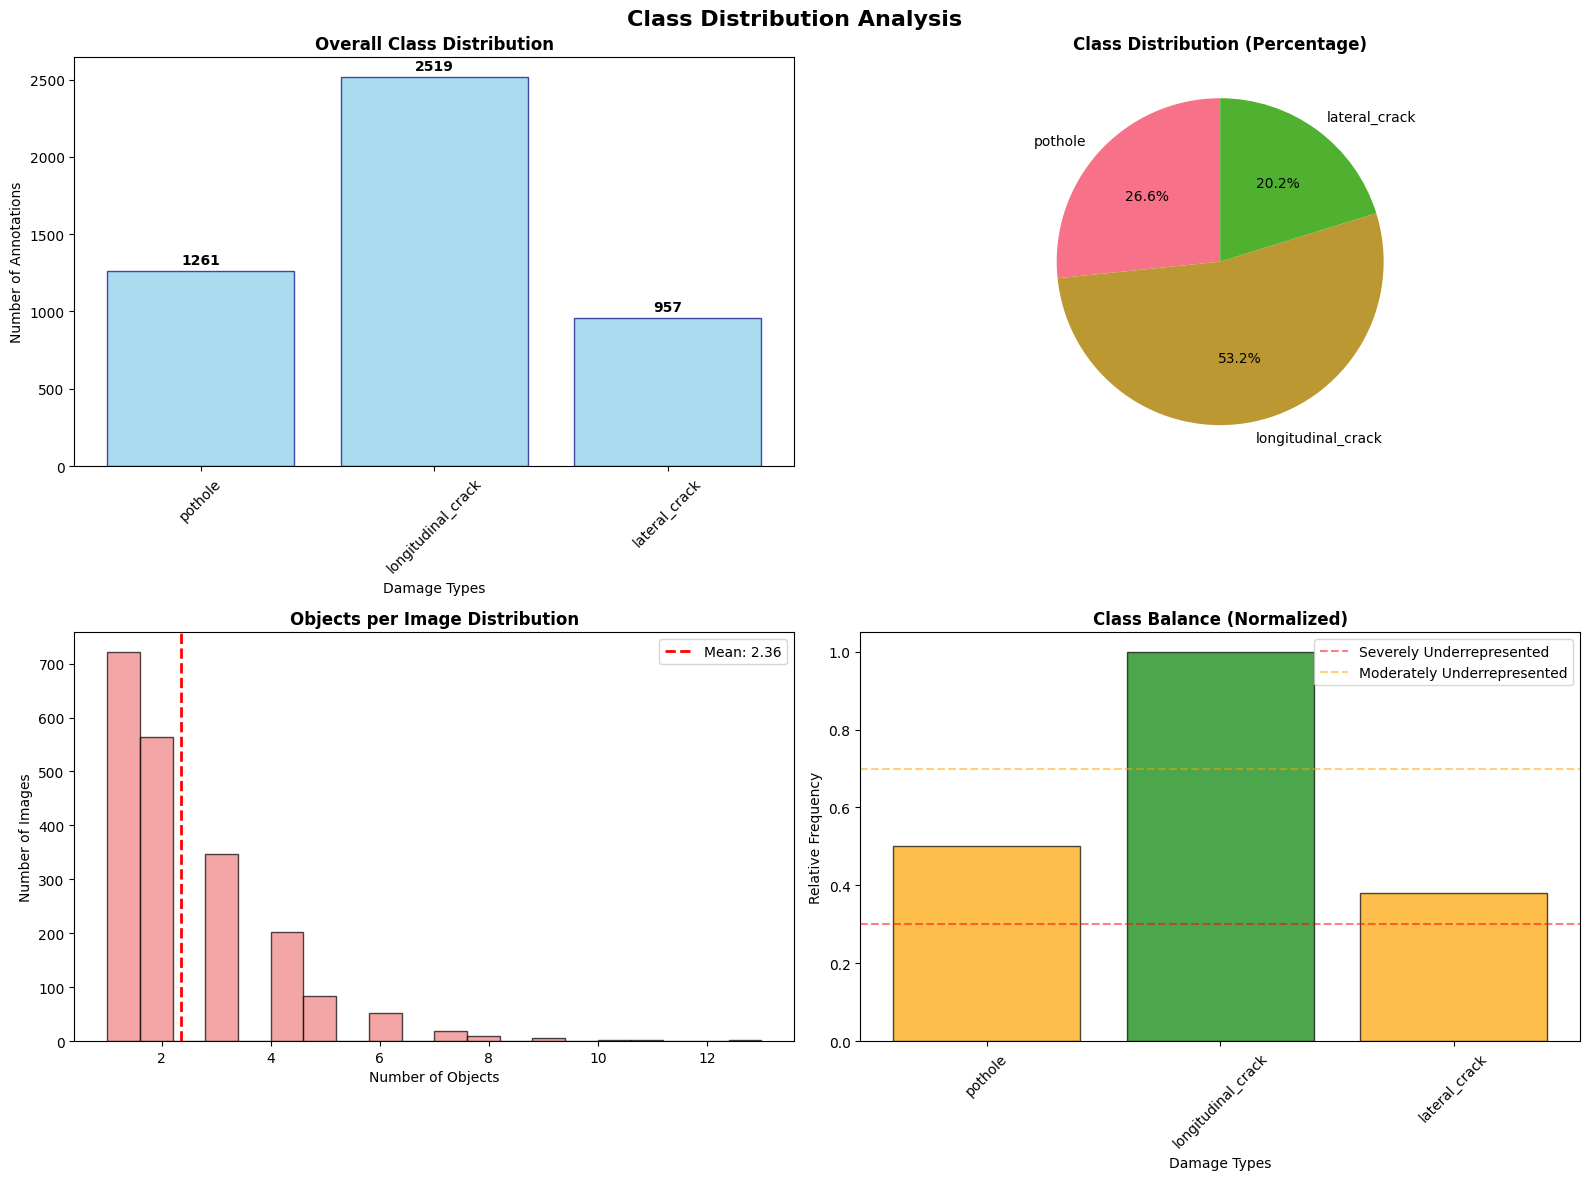

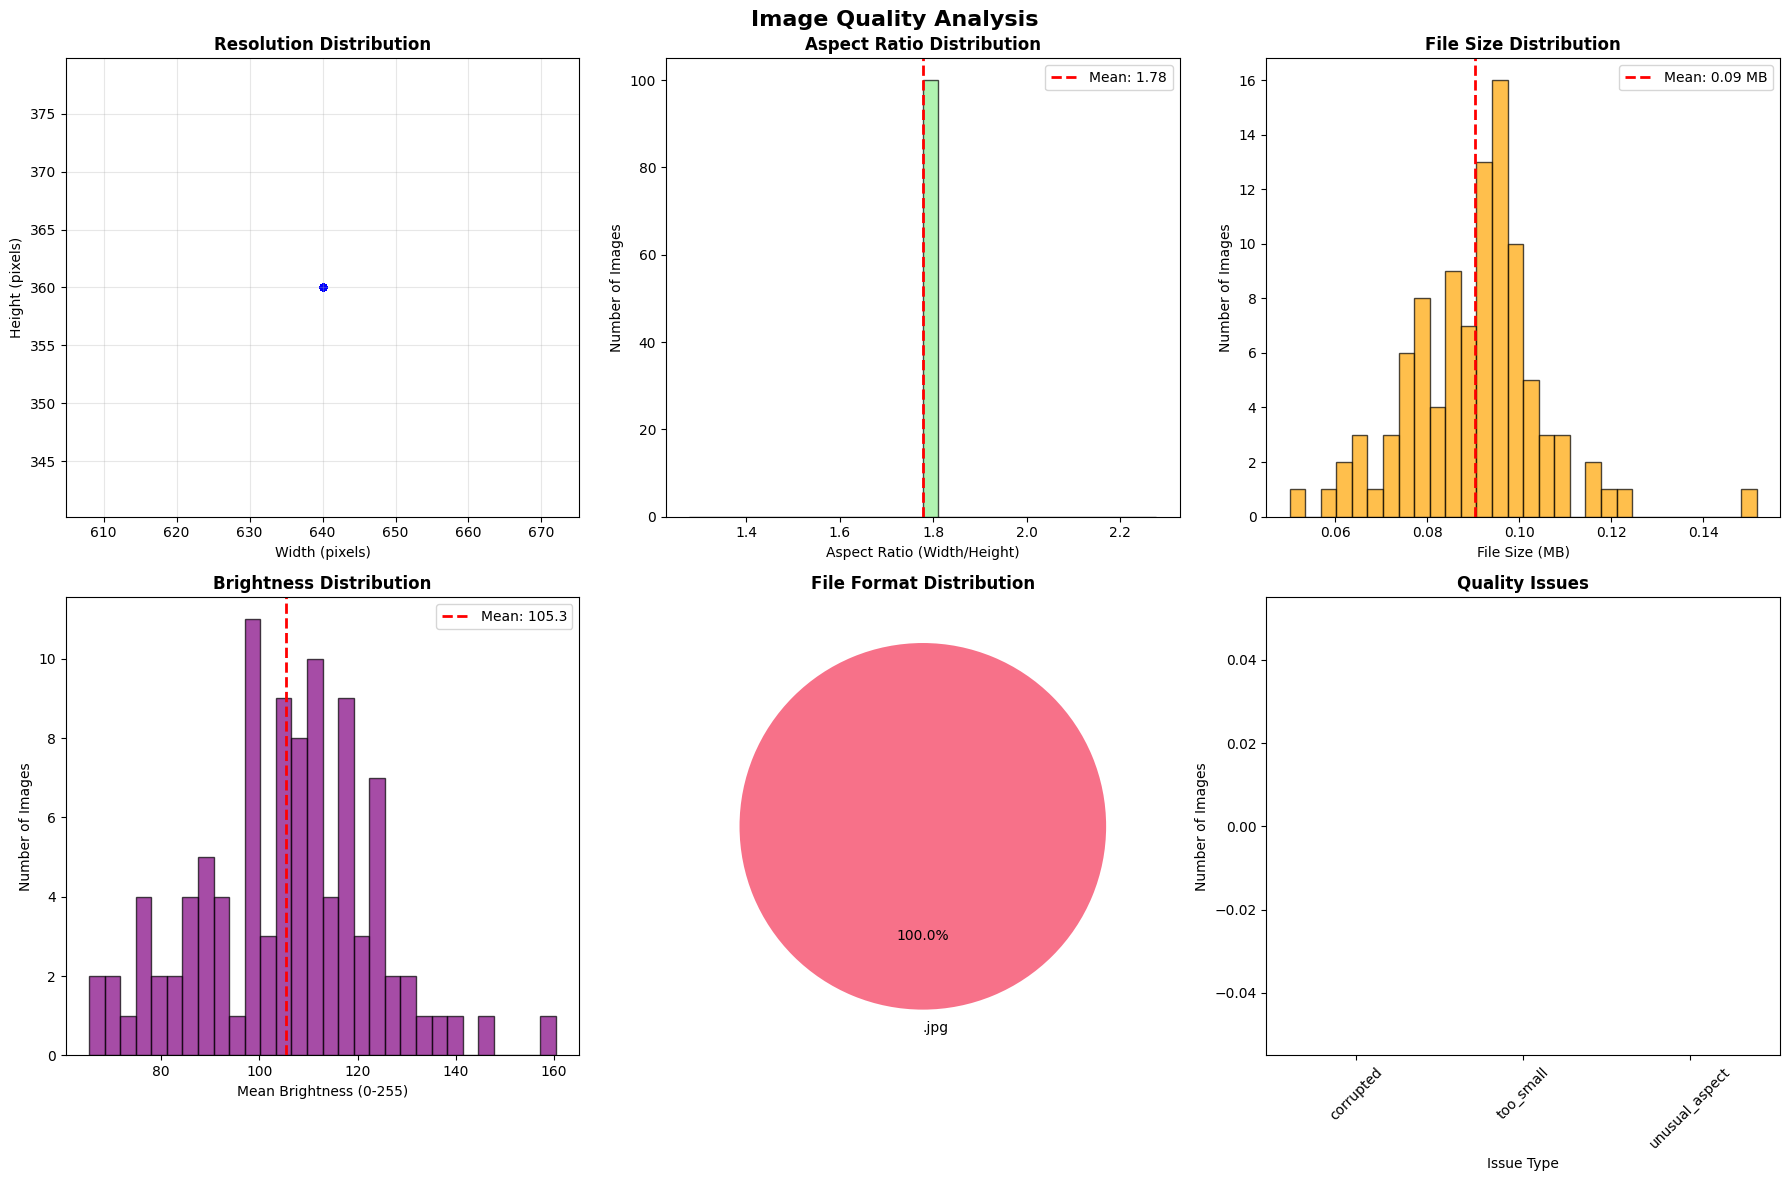

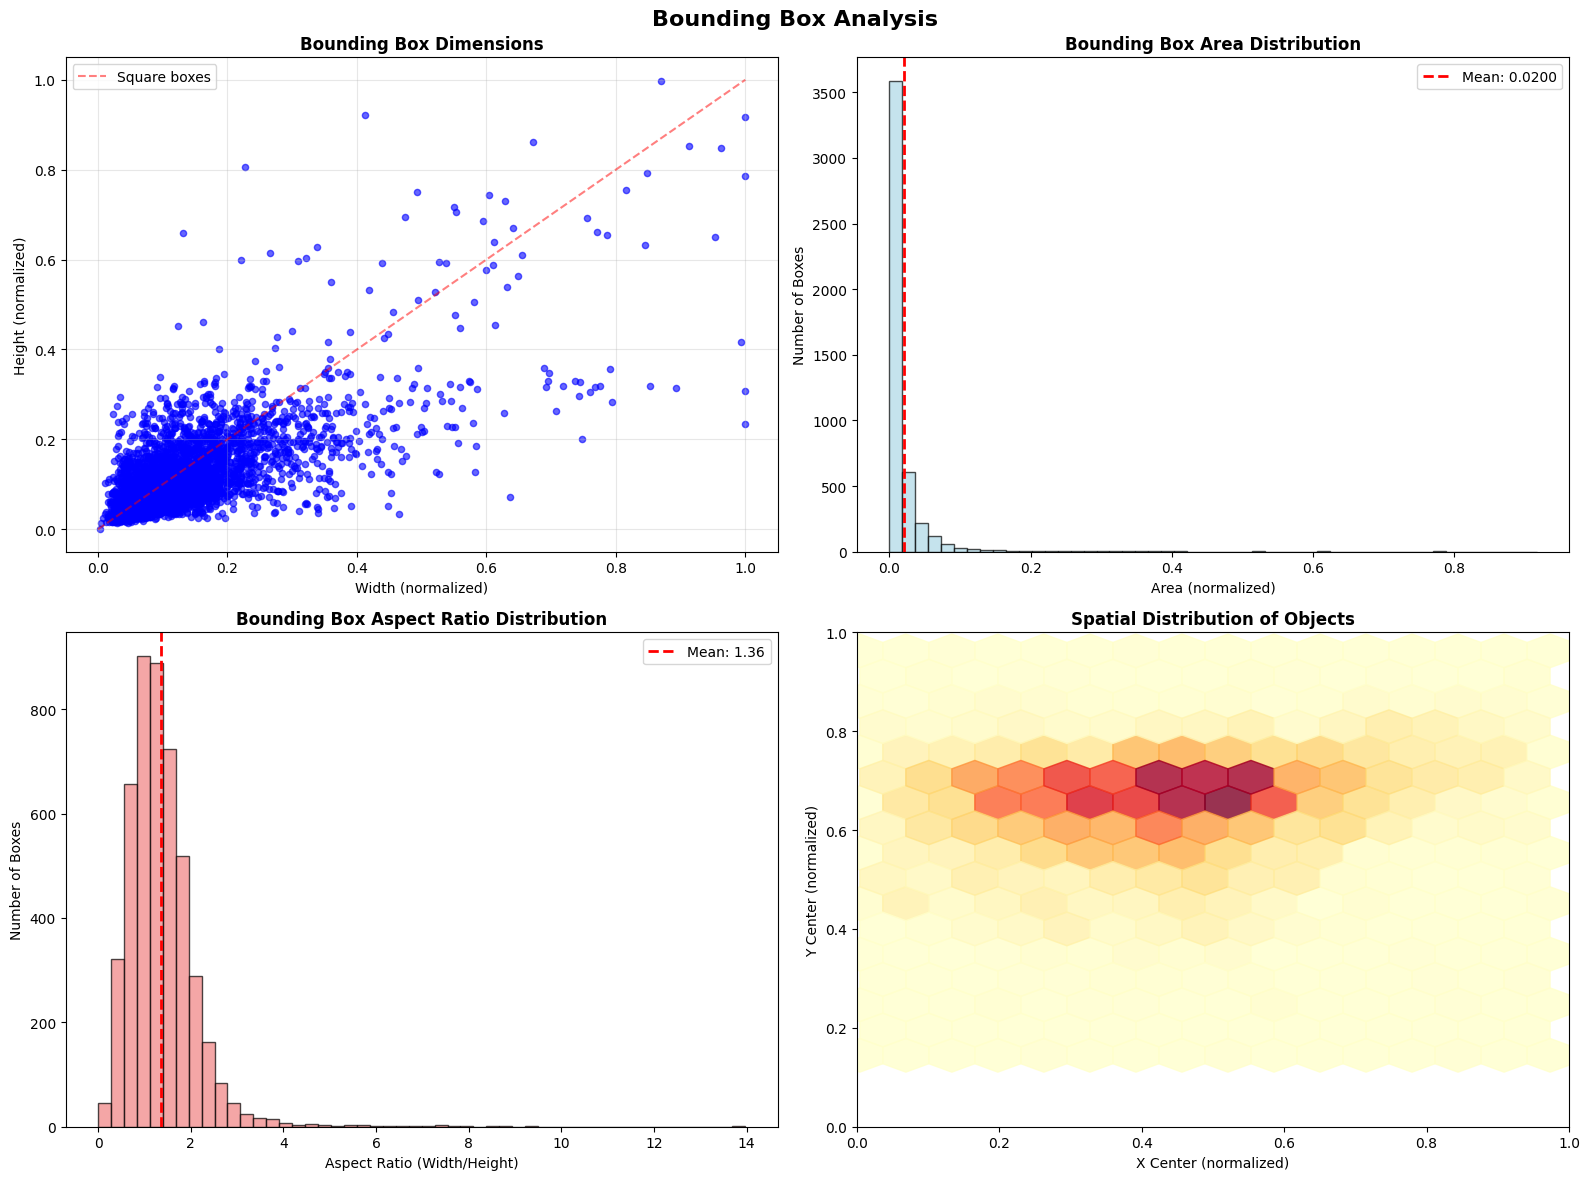

SUCCESS: All visualizations created!


In [33]:
def create_visualizations(explorer):
    """
    Create comprehensive visualizations of the dataset
    """
    if not explorer or not explorer.dataset_info:
        print("ERROR: Cannot create visualizations - dataset not analyzed")
        return
    
    print("CREATING VISUALIZATIONS")
    print("=" * 50)
    
    # Set up the plot style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # 1. Class Distribution Visualization
    if 'annotations' in explorer.dataset_info:
        create_class_distribution_plots(explorer)
    
    # 2. Image Quality Visualizations
    if 'images' in explorer.dataset_info:
        create_image_quality_plots(explorer)
    
    # 3. Bounding Box Analysis
    if 'annotations' in explorer.dataset_info:
        create_bbox_analysis_plots(explorer)
    
    print("SUCCESS: All visualizations created!")

def create_class_distribution_plots(explorer):
    """
    Create class distribution visualizations
    """
    annotations = explorer.dataset_info['annotations']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Class Distribution Analysis', fontsize=16, fontweight='bold')
    
    # Overall class distribution
    classes = []
    counts = []
    for class_id, count in sorted(annotations['class_distribution'].items()):
        class_name = explorer.class_mapping.get(class_id, f'Class_{class_id}')
        classes.append(class_name)
        counts.append(count)
    
    bars = axes[0, 0].bar(classes, counts, color='skyblue', edgecolor='navy', alpha=0.7)
    axes[0, 0].set_title('Overall Class Distribution', fontweight='bold')
    axes[0, 0].set_xlabel('Damage Types')
    axes[0, 0].set_ylabel('Number of Annotations')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, count in zip(bars, counts):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01, 
                       str(count), ha='center', va='bottom', fontweight='bold')
    
    # Pie chart
    axes[0, 1].pie(counts, labels=classes, autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('Class Distribution (Percentage)', fontweight='bold')
    
    # Objects per image distribution
    if len(annotations['objects_per_image']) > 0:
        axes[1, 0].hist(annotations['objects_per_image'], bins=20, 
                       color='lightcoral', alpha=0.7, edgecolor='black')
        axes[1, 0].set_title('Objects per Image Distribution', fontweight='bold')
        axes[1, 0].set_xlabel('Number of Objects')
        axes[1, 0].set_ylabel('Number of Images')
        axes[1, 0].axvline(np.mean(annotations['objects_per_image']), 
                          color='red', linestyle='--', linewidth=2, 
                          label=f'Mean: {np.mean(annotations["objects_per_image"]):.2f}')
        axes[1, 0].legend()
    
    # Class balance visualization
    if len(counts) > 1:
        max_count = max(counts)
        normalized_counts = [c/max_count for c in counts]
        
        bars = axes[1, 1].bar(classes, normalized_counts, 
                             color=['red' if nc < 0.3 else 'orange' if nc < 0.7 else 'green' for nc in normalized_counts],
                             alpha=0.7, edgecolor='black')
        axes[1, 1].set_title('Class Balance (Normalized)', fontweight='bold')
        axes[1, 1].set_xlabel('Damage Types')
        axes[1, 1].set_ylabel('Relative Frequency')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].axhline(y=0.3, color='red', linestyle='--', alpha=0.5, label='Severely Underrepresented')
        axes[1, 1].axhline(y=0.7, color='orange', linestyle='--', alpha=0.5, label='Moderately Underrepresented')
        axes[1, 1].legend()
    
    plt.tight_layout()
    
    if CONFIG['SAVE_PLOTS']:
        plt.savefig(f"{CONFIG['OUTPUT_DIR']}/class_distribution.png", 
                   dpi=CONFIG['DPI'], bbox_inches='tight')
    plt.show()

def create_image_quality_plots(explorer):
    """
    Create image quality visualizations
    """
    images = explorer.dataset_info['images']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Image Quality Analysis', fontsize=16, fontweight='bold')
    
    # Resolution distribution
    axes[0, 0].scatter(images['widths'], images['heights'], alpha=0.6, s=20, color='blue')
    axes[0, 0].set_title('Resolution Distribution', fontweight='bold')
    axes[0, 0].set_xlabel('Width (pixels)')
    axes[0, 0].set_ylabel('Height (pixels)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Aspect ratio distribution
    axes[0, 1].hist(images['aspect_ratios'], bins=30, 
                   color='lightgreen', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Aspect Ratio Distribution', fontweight='bold')
    axes[0, 1].set_xlabel('Aspect Ratio (Width/Height)')
    axes[0, 1].set_ylabel('Number of Images')
    axes[0, 1].axvline(np.mean(images['aspect_ratios']), 
                      color='red', linestyle='--', linewidth=2,
                      label=f'Mean: {np.mean(images["aspect_ratios"]):.2f}')
    axes[0, 1].legend()
    
    # File size distribution
    file_sizes_mb = images['file_sizes'] / (1024 * 1024)
    axes[0, 2].hist(file_sizes_mb, bins=30, 
                   color='orange', alpha=0.7, edgecolor='black')
    axes[0, 2].set_title('File Size Distribution', fontweight='bold')
    axes[0, 2].set_xlabel('File Size (MB)')
    axes[0, 2].set_ylabel('Number of Images')
    axes[0, 2].axvline(np.mean(file_sizes_mb), 
                      color='red', linestyle='--', linewidth=2,
                      label=f'Mean: {np.mean(file_sizes_mb):.2f} MB')
    axes[0, 2].legend()
    
    # Brightness distribution
    if len(images['color_stats']['mean_brightness']) > 0:
        axes[1, 0].hist(images['color_stats']['mean_brightness'], bins=30,
                       color='purple', alpha=0.7, edgecolor='black')
        axes[1, 0].set_title('Brightness Distribution', fontweight='bold')
        axes[1, 0].set_xlabel('Mean Brightness (0-255)')
        axes[1, 0].set_ylabel('Number of Images')
        axes[1, 0].axvline(np.mean(images['color_stats']['mean_brightness']), 
                          color='red', linestyle='--', linewidth=2,
                          label=f'Mean: {np.mean(images["color_stats"]["mean_brightness"]):.1f}')
        axes[1, 0].legend()
    
    # Format distribution
    formats = list(images['formats'].keys())
    format_counts = list(images['formats'].values())
    axes[1, 1].pie(format_counts, labels=formats, autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('File Format Distribution', fontweight='bold')
    
    # Quality issues
    issues = list(images['quality_issues'].keys())
    issue_counts = list(images['quality_issues'].values())
    colors = ['red' if count > 0 else 'green' for count in issue_counts]
    
    bars = axes[1, 2].bar(issues, issue_counts, color=colors, alpha=0.7)
    axes[1, 2].set_title('Quality Issues', fontweight='bold')
    axes[1, 2].set_xlabel('Issue Type')
    axes[1, 2].set_ylabel('Number of Images')
    axes[1, 2].tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, count in zip(bars, issue_counts):
        if count > 0:
            axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                           str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    
    if CONFIG['SAVE_PLOTS']:
        plt.savefig(f"{CONFIG['OUTPUT_DIR']}/image_quality.png", 
                   dpi=CONFIG['DPI'], bbox_inches='tight')
    plt.show()

def create_bbox_analysis_plots(explorer):
    """
    Create bounding box analysis visualizations
    """
    annotations = explorer.dataset_info['annotations']
    bbox_stats = annotations['bbox_stats']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Bounding Box Analysis', fontsize=16, fontweight='bold')
    
    # Width vs Height scatter
    axes[0, 0].scatter(bbox_stats['widths'], bbox_stats['heights'], alpha=0.6, s=20, color='blue')
    axes[0, 0].set_title('Bounding Box Dimensions', fontweight='bold')
    axes[0, 0].set_xlabel('Width (normalized)')
    axes[0, 0].set_ylabel('Height (normalized)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add diagonal line for square boxes
    max_dim = max(np.max(bbox_stats['widths']), np.max(bbox_stats['heights']))
    axes[0, 0].plot([0, max_dim], [0, max_dim], 'r--', alpha=0.5, label='Square boxes')
    axes[0, 0].legend()
    
    # Area distribution
    axes[0, 1].hist(bbox_stats['areas'], bins=50, 
                   color='lightblue', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Bounding Box Area Distribution', fontweight='bold')
    axes[0, 1].set_xlabel('Area (normalized)')
    axes[0, 1].set_ylabel('Number of Boxes')
    axes[0, 1].axvline(np.mean(bbox_stats['areas']), 
                      color='red', linestyle='--', linewidth=2,
                      label=f'Mean: {np.mean(bbox_stats["areas"]):.4f}')
    axes[0, 1].legend()
    
    # Aspect ratio distribution
    axes[1, 0].hist(bbox_stats['aspect_ratios'], bins=50,
                   color='lightcoral', alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Bounding Box Aspect Ratio Distribution', fontweight='bold')
    axes[1, 0].set_xlabel('Aspect Ratio (Width/Height)')
    axes[1, 0].set_ylabel('Number of Boxes')
    axes[1, 0].axvline(np.mean(bbox_stats['aspect_ratios']), 
                      color='red', linestyle='--', linewidth=2,
                      label=f'Mean: {np.mean(bbox_stats["aspect_ratios"]):.2f}')
    axes[1, 0].legend()
    
    # Spatial distribution heatmap
    spatial = annotations['spatial_distribution']
    if len(spatial['x_centers']) > 0 and len(spatial['y_centers']) > 0:
        axes[1, 1].hexbin(spatial['x_centers'], spatial['y_centers'], 
                         gridsize=15, cmap='YlOrRd', alpha=0.8)
        axes[1, 1].set_title('Spatial Distribution of Objects', fontweight='bold')
        axes[1, 1].set_xlabel('X Center (normalized)')
        axes[1, 1].set_ylabel('Y Center (normalized)')
        axes[1, 1].set_xlim(0, 1)
        axes[1, 1].set_ylim(0, 1)
    
    plt.tight_layout()
    
    if CONFIG['SAVE_PLOTS']:
        plt.savefig(f"{CONFIG['OUTPUT_DIR']}/bbox_analysis.png", 
                   dpi=CONFIG['DPI'], bbox_inches='tight')
    plt.show()

# Create all visualizations
if explorer and (annotation_stats or image_stats):
    create_visualizations(explorer)
else:
    print("ERROR: Cannot create visualizations - no data available")

## Sample Image Visualization

VISUALIZING SAMPLE IMAGES WITH ANNOTATIONS


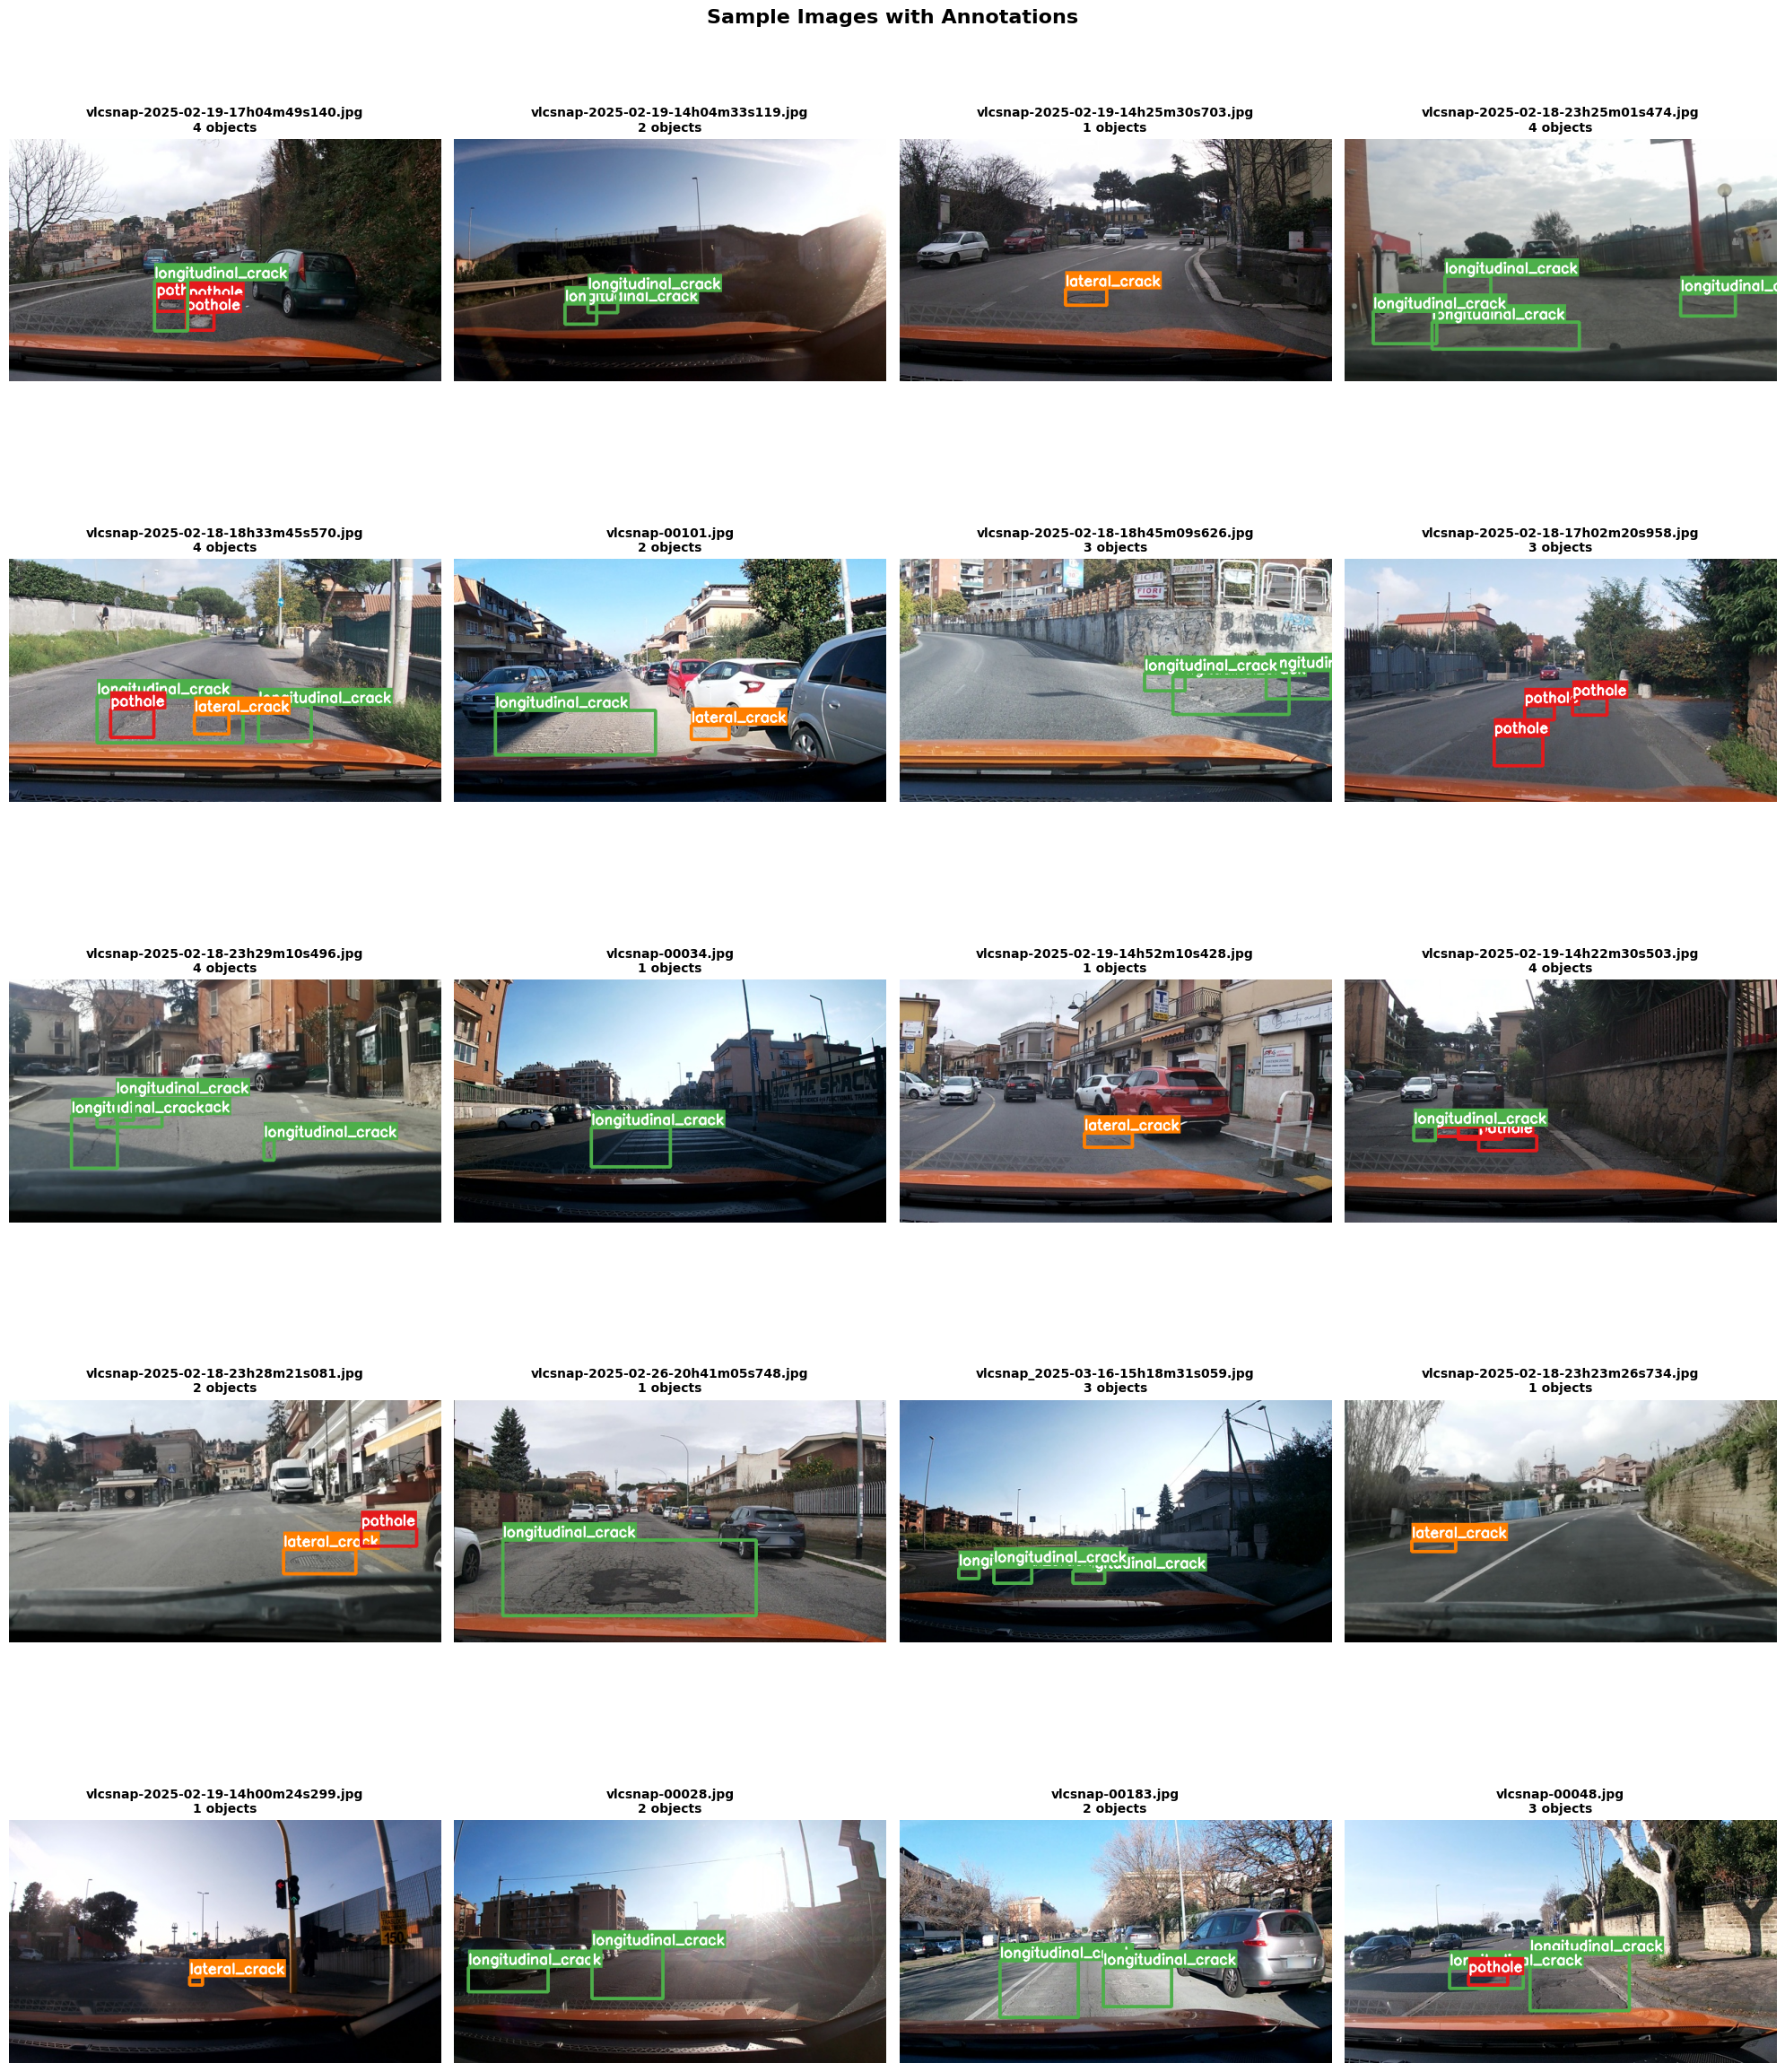

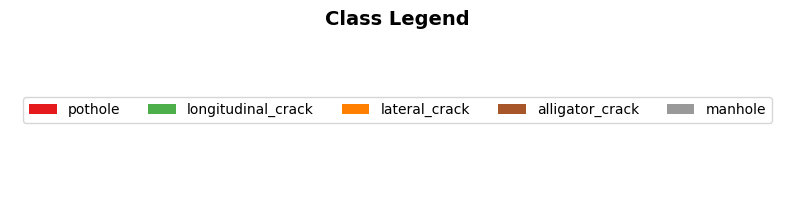

In [34]:
def visualize_sample_images_with_annotations(explorer, num_samples=12):
    """
    Display sample images with their annotations overlaid
    """
    if not explorer:
        print("ERROR: Cannot visualize samples - dataset not loaded")
        return
    
    print("VISUALIZING SAMPLE IMAGES WITH ANNOTATIONS")
    print("=" * 50)
    
    # Find images with annotations
    sample_pairs = []
    
    for split in ['train', 'val', 'test']:
        img_dir = explorer.data_dir / 'images' / split
        lbl_dir = explorer.data_dir / 'labels' / split
        
        if img_dir.exists() and lbl_dir.exists():
            # Find matching image-label pairs
            for img_file in img_dir.glob('*.[jJ][pP][gG]'):
                label_file = lbl_dir / f"{img_file.stem}.txt"
                if label_file.exists():
                    sample_pairs.append((img_file, label_file))
    
    if not sample_pairs:
        print("ERROR: No matching image-label pairs found")
        return
    
    # Sample random pairs
    selected_pairs = np.random.choice(len(sample_pairs), 
                                     min(num_samples, len(sample_pairs)), 
                                     replace=False)
    
    # Create grid layout
    cols = 4
    rows = (num_samples + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    fig.suptitle('Sample Images with Annotations', fontsize=16, fontweight='bold')
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    # Define colors for each class
    colors = plt.cm.Set1(np.linspace(0, 1, len(explorer.class_mapping)))
    
    for idx, pair_idx in enumerate(selected_pairs):
        row = idx // cols
        col = idx % cols
        
        img_path, label_path = sample_pairs[pair_idx]
        
        try:
            # Load image
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w = img.shape[:2]
            
            # Load annotations
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            # Draw bounding boxes
            img_annotated = img.copy()
            annotation_count = 0
            
            for line in lines:
                line = line.strip()
                if not line:
                    continue
                
                try:
                    parts = line.split()
                    if len(parts) != 5:
                        continue
                    
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:5])
                    
                    # Convert YOLO format to pixel coordinates
                    x1 = int((x_center - width/2) * w)
                    y1 = int((y_center - height/2) * h)
                    x2 = int((x_center + width/2) * w)
                    y2 = int((y_center + height/2) * h)
                    
                    # Get color for this class
                    color = colors[class_id % len(colors)]
                    color_bgr = tuple(int(c * 255) for c in color[:3])
                    
                    # Draw rectangle
                    cv2.rectangle(img_annotated, (x1, y1), (x2, y2), color_bgr, 3)
                    
                    # Add label
                    class_name = explorer.class_mapping.get(class_id, f'Class_{class_id}')
                    label_text = f'{class_name}'
                    
                    # Text background
                    (text_w, text_h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
                    cv2.rectangle(img_annotated, (x1, y1-text_h-10), (x1+text_w, y1), color_bgr, -1)
                    cv2.putText(img_annotated, label_text, (x1, y1-5), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                    
                    annotation_count += 1
                    
                except (ValueError, IndexError):
                    continue
            
            # Display image
            axes[row, col].imshow(img_annotated)
            axes[row, col].set_title(f'{img_path.name}\n{annotation_count} objects', 
                                   fontsize=10, fontweight='bold')
            axes[row, col].axis('off')
            
        except Exception as e:
            axes[row, col].text(0.5, 0.5, f'Error loading\n{img_path.name}', 
                               ha='center', va='center', transform=axes[row, col].transAxes)
            axes[row, col].axis('off')
    
    # Hide unused subplots
    for idx in range(len(selected_pairs), rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    
    if CONFIG['SAVE_PLOTS']:
        plt.savefig(f"{CONFIG['OUTPUT_DIR']}/sample_images_with_annotations.png", 
                   dpi=CONFIG['DPI'], bbox_inches='tight')
    plt.show()
    
    # Create legend
    fig_legend, ax_legend = plt.subplots(1, 1, figsize=(10, 2))
    
    legend_elements = []
    for class_id, class_name in explorer.class_mapping.items():
        color = colors[class_id % len(colors)]
        legend_elements.append(plt.Rectangle((0, 0), 1, 1, facecolor=color, label=class_name))
    
    ax_legend.legend(handles=legend_elements, loc='center', ncol=len(explorer.class_mapping))
    ax_legend.axis('off')
    ax_legend.set_title('Class Legend', fontweight='bold', fontsize=14)
    
    if CONFIG['SAVE_PLOTS']:
        plt.savefig(f"{CONFIG['OUTPUT_DIR']}/class_legend.png", 
                   dpi=CONFIG['DPI'], bbox_inches='tight')
    plt.show()

# Visualize sample images
if explorer:
    visualize_sample_images_with_annotations(explorer, CONFIG['MAX_IMAGES_DISPLAY'])
else:
    print("ERROR: Cannot visualize samples - dataset not loaded")

## Data Quality Assessment and Final Summary

In [35]:
def generate_final_summary(explorer):
    """
    Generate final exploration summary with actionable insights
    """
    print("\n" + "=" * 80)
    print("ROAD DAMAGE DATASET EXPLORATION - FINAL SUMMARY")
    print("=" * 80)
    
    if not explorer:
        print("ERROR: Dataset exploration was not completed successfully.")
        print("Please ensure the dataset is properly downloaded and extracted.")
        return
    
    # Dataset Overview
    structure = explorer.dataset_info.get('structure', {})
    annotations = explorer.dataset_info.get('annotations', {})
    images = explorer.dataset_info.get('images', {})
    
    print(f"DATASET OVERVIEW:")
    print(f"  Dataset Path: {explorer.data_dir}")
    print(f"  Total Images: {structure.get('total_images', 0):,}")
    print(f"  Total Annotations: {sum(annotations.get('class_distribution', {}).values()):,}")
    print(f"  Number of Classes: {len(explorer.class_mapping)}")
    print(f"  Classes: {', '.join(explorer.class_mapping.values())}")
    print(f"  YOLO Format: {'YES' if structure.get('has_yolo_structure') else 'NO'}")
    
    # Split Information
    splits = structure.get('splits', {})
    if splits:
        print(f"\nSPLIT BREAKDOWN:")
        for split, info in splits.items():
            if info['images'] > 0:
                print(f"  {split.upper()}: {info['images']:,} images, {info['labels']:,} labels")
    
    # Key Statistics
    if annotations:
        print(f"\nKEY STATISTICS:")
        if annotations.get('objects_per_image') is not None and len(annotations['objects_per_image']) > 0:
            print(f"  Avg Objects per Image: {np.mean(annotations['objects_per_image']):.2f}")
            print(f"  Max Objects per Image: {np.max(annotations['objects_per_image'])}")
        
        bbox_stats = annotations.get('bbox_stats', {})
        if bbox_stats.get('areas') is not None and len(bbox_stats['areas']) > 0:
            print(f"  Avg Bbox Area: {np.mean(bbox_stats['areas']):.4f} (normalized)")
            print(f"  Avg Aspect Ratio: {np.mean(bbox_stats['aspect_ratios']):.2f}")
    
    # Class Distribution
    if annotations and annotations.get('class_distribution'):
        print(f"\nCLASS DISTRIBUTION:")
        total_objects = sum(annotations['class_distribution'].values())
        for class_id, count in sorted(annotations['class_distribution'].items()):
            class_name = explorer.class_mapping.get(class_id, f'Class_{class_id}')
            percentage = (count / total_objects * 100) if total_objects > 0 else 0
            print(f"  {class_name}: {count:,} ({percentage:.1f}%)")
    
    # Quality Assessment
    print(f"\nQUALITY ASSESSMENT:")
    
    # Structure quality
    structure_ok = structure.get('has_yolo_structure', False)
    print(f"  Structure: {'GOOD' if structure_ok else 'NEEDS WORK'}")
    
    # Annotation quality
    if annotations:
        quality = annotations.get('annotation_quality', {})
        total_annotations = sum(quality.values())
        if total_annotations > 0:
            quality_percentage = (quality.get('valid', 0) / total_annotations) * 100
            print(f"  Annotation Quality: {quality_percentage:.1f}% valid")
        
        # Class balance
        class_counts = list(annotations.get('class_distribution', {}).values())
        if class_counts and len(class_counts) > 1:
            imbalance_ratio = max(class_counts) / min(class_counts)
            if imbalance_ratio < 3:
                balance_status = "WELL BALANCED"
            elif imbalance_ratio < 10:
                balance_status = "MODERATELY IMBALANCED"
            else:
                balance_status = "SEVERELY IMBALANCED"
            print(f"  Class Balance: {balance_status} (ratio: {imbalance_ratio:.1f}:1)")
    
    # Image quality
    if images:
        quality_issues = images.get('quality_issues', {})
        total_issues = sum(quality_issues.values())
        sample_size = len(images.get('widths', []))
        
        if sample_size > 0:
            issue_percentage = (total_issues / sample_size) * 100
            print(f"  Image Quality: {issue_percentage:.1f}% have issues")
    
    # Generated Outputs
    print(f"\nGENERATED OUTPUTS:")
    output_files = list(Path(CONFIG['OUTPUT_DIR']).glob('*.*'))
    if output_files:
        for file_path in output_files:
            print(f"  {file_path.name}")
    else:
        print(f"  Output directory: {CONFIG['OUTPUT_DIR']}")
    
    # Training Readiness Assessment
    total_images = structure.get('total_images', 0)
    
    print(f"\nTRAINING READINESS ASSESSMENT:")
    
    ready_for_training = True
    issues = []
    
    if not structure_ok:
        ready_for_training = False
        issues.append("Dataset not in YOLO format")
    
    if total_images < 500:
        ready_for_training = False
        issues.append("Very small dataset size")
    
    if annotations:
        quality = annotations.get('annotation_quality', {})
        total_annotations = sum(quality.values())
        if total_annotations > 0:
            quality_percentage = (quality.get('valid', 0) / total_annotations) * 100
            if quality_percentage < 90:
                issues.append(f"Low annotation quality ({quality_percentage:.1f}%)")
    
    if ready_for_training and not issues:
        print("  STATUS: READY FOR YOLOV8 TRAINING")
        print("  RECOMMENDATION: Proceed with YOLOv8 training notebook")
    else:
        print("  STATUS: NEEDS ATTENTION BEFORE TRAINING")
        print("  ISSUES TO ADDRESS:")
        for issue in issues:
            print(f"    - {issue}")
    
    # Training Configuration Recommendations
    print(f"\nTRAINING CONFIGURATION RECOMMENDATIONS:")
    
    # Image size recommendation
    if images and images.get('widths') is not None:
        median_width = np.median(images['widths'])
        median_height = np.median(images['heights'])
        
        if median_width <= 416 and median_height <= 416:
            recommended_size = 416
        elif median_width <= 640 and median_height <= 640:
            recommended_size = 640
        else:
            recommended_size = 832
        
        print(f"  Recommended Image Size: {recommended_size}x{recommended_size}")
        print(f"  Median Image Size: {median_width:.0f}x{median_height:.0f}")
    
    # Model size recommendation
    if total_images < 1000:
        print(f"  Recommended Model: YOLOv8n (nano) - small dataset")
    elif total_images < 5000:
        print(f"  Recommended Model: YOLOv8s (small) - medium dataset")
    else:
        print(f"  Recommended Model: YOLOv8m (medium) - large dataset")
    
    # Batch size recommendation
    if total_images < 500:
        print(f"  Recommended Batch Size: 8-16")
    elif total_images < 2000:
        print(f"  Recommended Batch Size: 16-32")
    else:
        print(f"  Recommended Batch Size: 32-64")
    
    # Class weights recommendation
    if annotations and annotations.get('class_distribution'):
        class_counts = list(annotations['class_distribution'].values())
        if len(class_counts) > 1:
            imbalance_ratio = max(class_counts) / min(class_counts)
            if imbalance_ratio > 3:
                print(f"  Recommendation: Use class weights or focal loss (imbalance ratio: {imbalance_ratio:.1f})")
            else:
                print(f"  Recommendation: Standard training (classes well balanced)")
    
    print("\n" + "=" * 80)
    print("SUCCESS: Dataset exploration completed!")
    if ready_for_training:
        print("READY: Proceed with YOLOv8 training.")
    else:
        print("ATTENTION: Address issues before training.")
    print("=" * 80)
    
    # Save summary to JSON
    if CONFIG['GENERATE_REPORT']:
        summary_data = {
            'dataset_overview': {
                'total_images': structure.get('total_images', 0),
                'total_annotations': sum(annotations.get('class_distribution', {}).values()),
                'num_classes': len(explorer.class_mapping),
                'class_names': explorer.class_mapping,
                'has_yolo_structure': structure.get('has_yolo_structure', False)
            },
            'quality_assessment': {
                'ready_for_training': ready_for_training,
                'issues': issues
            },
            'recommendations': {
                'image_size': recommended_size if 'recommended_size' in locals() else 640,
                'model_size': 'yolov8n' if total_images < 1000 else 'yolov8s' if total_images < 5000 else 'yolov8m',
                'batch_size': '8-16' if total_images < 500 else '16-32' if total_images < 2000 else '32-64'
            },
            'generated_date': datetime.now().isoformat()
        }
        
        report_path = f"{CONFIG['OUTPUT_DIR']}/exploration_summary.json"
        with open(report_path, 'w') as f:
            json.dump(summary_data, f, indent=4)
        print(f"\nSummary saved to: {report_path}")

# Generate final summary
if explorer:
    generate_final_summary(explorer)
else:
    print("Dataset exploration incomplete - please check dataset location and format.")


ROAD DAMAGE DATASET EXPLORATION - FINAL SUMMARY
DATASET OVERVIEW:
  Dataset Path: road_damage_data
  Total Images: 2,009
  Total Annotations: 4,737
  Number of Classes: 5
  Classes: pothole, longitudinal_crack, lateral_crack, alligator_crack, manhole
  YOLO Format: YES

SPLIT BREAKDOWN:
  TRAIN: 1,840 images, 1,840 labels
  VAL: 146 images, 146 labels
  TEST: 23 images, 23 labels

KEY STATISTICS:
  Avg Objects per Image: 2.36
  Max Objects per Image: 13
  Avg Bbox Area: 0.0200 (normalized)
  Avg Aspect Ratio: 1.36

CLASS DISTRIBUTION:
  pothole: 1,261 (26.6%)
  longitudinal_crack: 2,519 (53.2%)
  lateral_crack: 957 (20.2%)

QUALITY ASSESSMENT:
  Structure: GOOD
  Annotation Quality: 100.0% valid
  Class Balance: WELL BALANCED (ratio: 2.6:1)
  Image Quality: 0.0% have issues

GENERATED OUTPUTS:
  bbox_analysis.png
  class_distribution.png
  class_legend.png
  image_quality.png
  sample_images_with_annotations.png

TRAINING READINESS ASSESSMENT:
  STATUS: READY FOR YOLOV8 TRAINING
  REC